## **Notebook PC1_Ativ1**
## Regularized Linear Classifier for the MNIST database.
## Design from scratch.
**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):** Arthur Felipe dos Santos Fernandes


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from keras.datasets import mnist

(Xp, y), (Xtp, yt) = mnist.load_data()
Xa = Xp.reshape(Xp.shape[0], 784)
Xta = Xtp.reshape(Xtp.shape[0], 784)

Xa = Xa / 255.0
Xta = Xta / 255.0

X0 = np.ones((Xp.shape[0],1))
X = np.hstack((X0,Xa))
Xt0 = np.ones((Xtp.shape[0],1))
Xt = np.hstack((Xt0,Xta))

print("Shape of X: ".ljust(10),  X.shape)
print("Shape of y: ".ljust(10),  y.shape)
print("Shape of Xt: ".ljust(10),  X.shape)
print("Shape of yt: ".ljust(10),  yt.shape)

Shape of X:  (60000, 785)
Shape of y:  (60000,)
Shape of Xt:  (60000, 785)
Shape of yt:  (10000,)


In [2]:
# Visualizing a random data point
import plotly.express as px

ind = np.random.randint(60000)
print('Data point: ', ind, '\n', 'Label: ', y[ind])
fig = px.imshow(255-Xp[ind], binary_string=True, width=200, height=200)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(margin=dict(l=1, r=1, t=1, b=1))
fig.show()

Data point:  29202 
 Label:  7


In [3]:
# Dataset balancing analysis
from tensorflow.keras.utils import to_categorical

yy = to_categorical(y)
yyt = to_categorical(yt)
sum_along_columns1 = np.sum(yy, axis = 0)
print(sum_along_columns1)   
sum_along_columns2 = np.sum(yyt, axis = 0)
print(sum_along_columns2)
fig1 = px.bar(x=range(10),y=sum_along_columns1, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the training dataset</b>")
fig1.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig1.show()
fig2 = px.bar(x=range(10),y=sum_along_columns2, width=600, height=400,
              labels=dict(x="Class", y="Number of examples"), title="<b>Number of examples per class in the test dataset</b>")
fig2.update_layout(xaxis = dict(tickmode = 'linear', dtick = 1), title_x=0.5)
fig2.show()

[5923. 6742. 5958. 6131. 5842. 5421. 5918. 6265. 5851. 5949.]
[ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]


In [4]:
partition = 0.7

# Mixing the dataset before partitioning
index = np.arange(0,X.shape[0])
np.random.shuffle(index)

training_set_size = int(X.shape[0] * partition)

index_training = index[:training_set_size]
index_validation = index[training_set_size:]


X_training = X[index_training]
y_training = yy[index_training]

X_validation = X[index_validation]
y_validation = yy[index_validation]

print("X_training:".ljust(20), X_training.shape)
print("y_training:".ljust(20), y_training.shape)

print("X_validation:".ljust(20), X_validation.shape)
print("y_validation:".ljust(20), y_validation.shape)

X_training:          (42000, 785)
y_training:          (42000, 10)
X_validation:        (18000, 785)
y_validation:        (18000, 10)


In [5]:
def get_class_from_sample(sample: np.ndarray):
    class_ = 1
    for i in sample:
        if i == 0:
            class_ += 1
        else:
            break
    return class_ 

In [6]:
def get_w(X, y, c): 
    w_1 = (np.matmul(np.transpose(X), X) + c * np.eye(X.shape[1]))
    w_2 = np.matmul(np.transpose(X), y)
    w,resid,rank,s = np.linalg.lstsq(w_1, w_2, rcond=None)
    return w


In [7]:
def get_rates_from_c_values(X, y, c_values, Ws = []):
    hit_rates = []
    
    if len(Ws) != 0:
        are_Ws_given = True
    else:
        are_Ws_given = False
        Ws = []

    for index, c in enumerate(c_values):
        #print(c)
        
        if are_Ws_given:
            W = Ws[index]
        else:
            W = get_w(X, y, c)
            Ws.append(W)

        y_estimate = np.matmul(X,W)
        hits = 0
        for index, estimate in enumerate(y_estimate):
            max_index = np.where(estimate == np.amax(estimate))[0][0]
            estimated_class = max_index + 1
            if estimated_class == get_class_from_sample(y[index]):
                hits += 1
        hit_rates.append(hits/y_estimate.shape[0])
    return hit_rates, Ws

In [8]:
c_values = [pow(2,d) for d in range(0, 11, 1)]

hit_rates_training, Ws = get_rates_from_c_values(X_training, y_training, c_values)

In [9]:
hit_rates_validation, _ = get_rates_from_c_values(X_validation, y_validation, c_values, Ws)

In [10]:
'''fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Crude search for the regularization coefficient")
axs[0].semilogx(c_values, hit_rates_training, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].semilogx(c_values, hit_rates_validation, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()'''

best_c_index = np.where(hit_rates_validation == np.amax(hit_rates_validation))[0][0]

best_c = c_values[best_c_index]

#print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation[best_c_index]))



In [11]:
step =  0.1 * (4 * best_c - best_c / 4)

fine_c_values = np.arange((best_c/4), (4*best_c) + step / 10, step)

hit_rates_training_fine, Ws_fine = get_rates_from_c_values(X_training, y_training, fine_c_values)

In [12]:
hit_rates_validation_fine, _ = get_rates_from_c_values(X_validation, y_validation, fine_c_values, Ws_fine)

In [13]:
"""fig, axs = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.suptitle("Fine search for the regularization coefficient")
axs[0].plot(fine_c_values, hit_rates_training_fine, 'o-')
axs[0].set_title("Performance on Training set")
axs[0].set_ylabel("Hit Rate")
axs[0].set_xlabel("Regularization Coefficient 'c'")
axs[0].grid()

axs[1].plot(fine_c_values, hit_rates_validation_fine, 'o-')
axs[1].set_title("Performance on Validation set")
axs[1].set_ylabel("Hit Rate")
axs[1].set_xlabel("Regularization Coefficient 'c'")
axs[1].grid()"""

best_c_index = np.where(hit_rates_validation_fine == np.amax(hit_rates_validation_fine))[0][0]

best_c = fine_c_values[best_c_index]

#print("Best c value: {} \nPerformance of this value: {}".format(best_c, hit_rates_validation_fine[best_c_index]))

In [14]:
W = get_w(X, yy, best_c)

In [15]:
yt_estimate = np.matmul(Xt,W)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
print(confusion_matrix)

Performance on test set: 0.8642
[[ 940    0   18    5    1   21   15    5   13   19]
 [   0 1104   64   16   23   16   11   44   55   14]
 [   1    2  831   25    6    5    5   17    9    3]
 [   2    2   20  886    0   88    0    7   31   13]
 [   1    2   14    5  883   24   16   17   26   66]
 [   9    1    0   14    2  632   16    0   27    2]
 [  18    5   23    9   10   25  889    1   19    1]
 [   1    1   24   23    1   19    0  894   14   63]
 [   7   18   34   17   10   42    6    0  761    6]
 [   1    0    4   10   46   20    0   43   19  822]]


In [16]:
sum = np.zeros(10)
for j in range(10):
    for i in range(10):
        if i != j:
            sum[j] = sum[j] + confusion_matrix[i,j]
    sum[j] = sum[j]/confusion_matrix[:,j].sum()

print(sum)

[0.04081633 0.02731278 0.19476744 0.12277228 0.10081466 0.29147982
 0.07202505 0.13035019 0.21868583 0.18533201]


#### **Visualization of the 10 vectors of weights W, without the bias.**



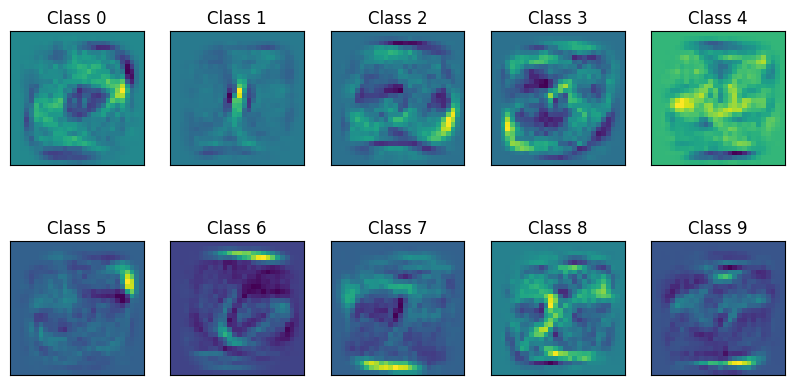

In [17]:
# Only for the MNIST dataset
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W[1:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight)
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

#### **To improve the visualization of the 10 vectors of weights W, the use of a divergent color map is indicated: the average value of the color map is a neutral color and the extreme values represent different colors. Using a divergent color map and a bilinear interpolation scheme (to facilitate the visualization of low-resolution images), the result of the visualization of the 10 vectors of weights W is illustrated in the following images.**

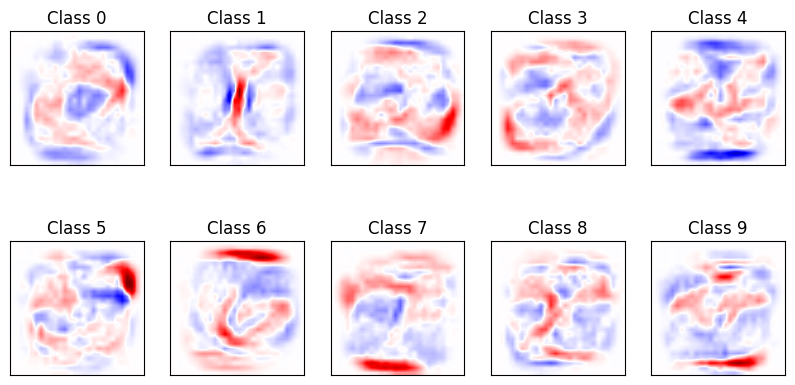

In [18]:
# Only for the MNIST dataset
scale = np.abs(W).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W[1:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

#### **Performance of the average 10 vectors of weights (here no bias is considered)**

In [19]:
W1 = np.zeros((784, 10))
for i in range(10):
  aux = np.mean(Xp[y==i], axis=0)
  aux = aux.reshape(784)/255
  aux = aux-np.mean(aux)
  W1[:,i] = aux/np.sqrt(np.sum(np.square(aux)))
yt_estimate = np.matmul(Xta,W1)
hits = 0
confusion_matrix = np.zeros([10, 10], dtype=int)
for index, estimate in enumerate(yt_estimate):
    max_index = np.where(estimate == np.amax(estimate))[0][0]
    estimated_class = max_index + 1
    if estimated_class == get_class_from_sample(yyt[index,:]):
        hits += 1
        confusion_matrix[estimated_class-1][estimated_class-1] += 1
    else:
        confusion_matrix[estimated_class-1][get_class_from_sample(yyt[index,:])-1] += 1

print("Performance on test set: {}".format(hits/yt_estimate.shape[0]))
print(confusion_matrix)

Performance on test set: 0.8208
[[ 902    0   27    6    4   27   29    8    7   16]
 [   0 1074   51    5   10   37   14   51   21   17]
 [   6    9  776   25    3    9   16   26   11    6]
 [   3    4   43  851    0  137    1    0   91   12]
 [   0    0   27    1  793   20   18   16   12   80]
 [  33    4    0   28    1  564   22    0   29   11]
 [  25    4   31    8   24   29  850    1   17    3]
 [   1    0   15   14    1   11    0  849   10   29]
 [  10   40   56   52   19   34    8   22  738   24]
 [   0    0    6   20  127   24    0   55   38  811]]


#### **Visualization of the average 10 vectors of weights**

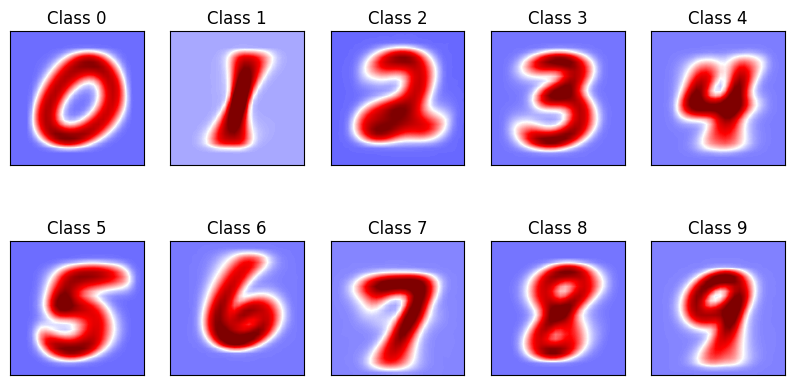

In [20]:
# Only for the MNIST dataset
scale = np.abs(W1).max()
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = W1[:,i].reshape([28,28])
    plt.title(f'Class {i}')
    plt.imshow(weight, cmap=plt.cm.seismic, vmin=-scale/2, vmax=scale/2, interpolation='bilinear')
    frame1 = plt.gca()
    frame1.axes.get_xaxis().set_visible(False)
    frame1.axes.get_yaxis().set_visible(False)

Image no. 11


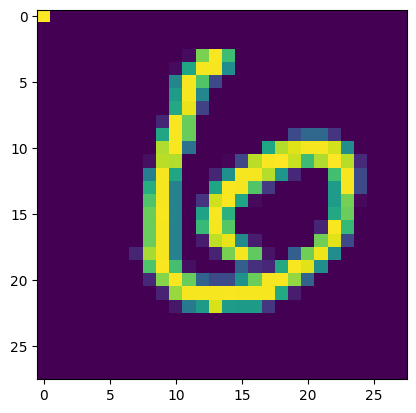

Real: 6
Predicted: 4
Rank of the correct answer: 6
Probabilities: [ 0.2344035   0.16069176  0.14971468  0.06913703  0.26389102 -0.17400486
  0.10095953 -0.07553308  0.17141296  0.05181571] 

Image no. 33


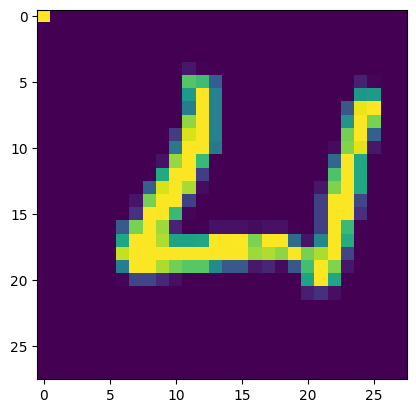

Real: 4
Predicted: 0
Rank of the correct answer: 4
Probabilities: [ 0.35845059 -0.08455628  0.1812747  -0.29922051  0.20366375  0.33781978
  0.22552617 -0.05079443  0.07592739 -0.04010936] 

Image no. 38


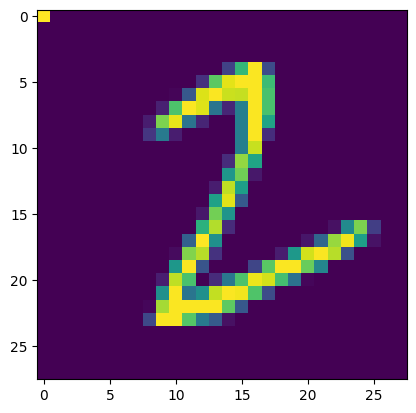

Real: 2
Predicted: 1
Rank of the correct answer: 5
Probabilities: [ 0.17249691  0.31698624  0.16484865  0.26119602 -0.28318569  0.08757432
  0.20884283 -0.05102544  0.12704516 -0.09350222] 

Image no. 43


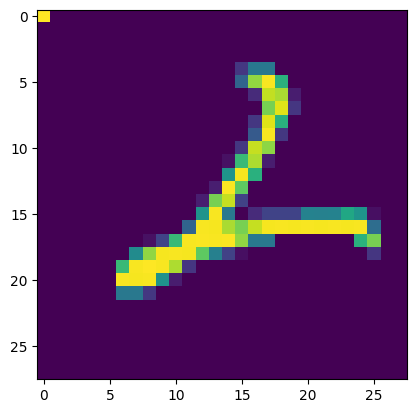

Real: 2
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.03469327  0.33227731  0.27943572  0.05419701  0.18465454  0.03928012
 -0.01111523 -0.04575413  0.13201297 -0.03458729] 

Image no. 45


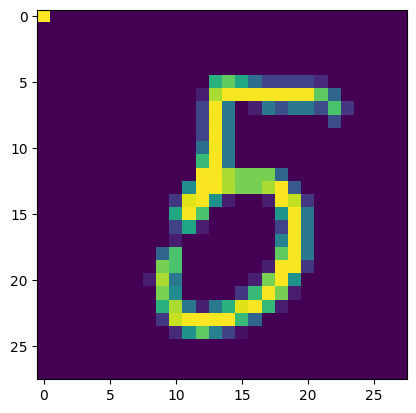

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.08727379 -0.12418142 -0.06194667  0.38226942  0.05653947  0.33789059
  0.17149562 -0.10338319  0.18624663 -0.01125874] 

Image no. 46


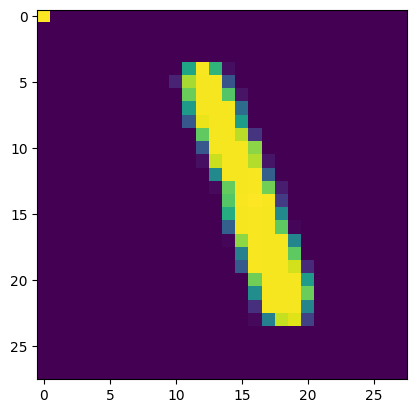

Real: 1
Predicted: 3
Rank of the correct answer: 2
Probabilities: [-0.27639744  0.31333585  0.14601131  0.33705365  0.07726481  0.19363085
  0.06894875  0.05522271 -0.00283716  0.07039978] 

Image no. 63


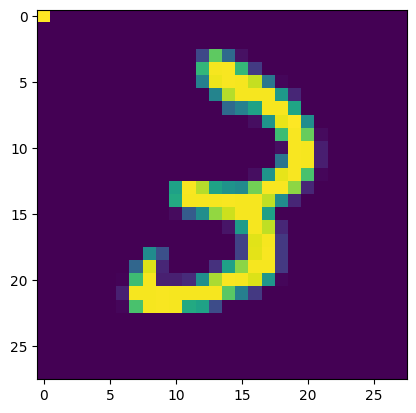

Real: 3
Predicted: 2
Rank of the correct answer: 3
Probabilities: [ 0.05063259  0.04588164  0.39904917  0.18717733  0.04060352 -0.01082341
 -0.02855646 -0.11580484  0.11012242  0.2805541 ] 

Image no. 66


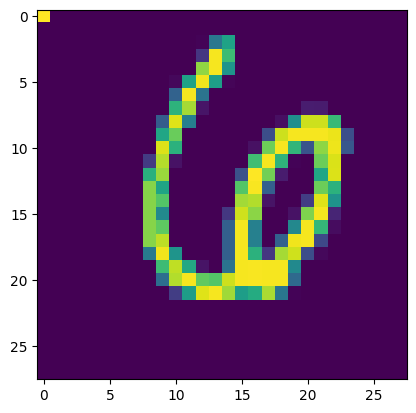

Real: 6
Predicted: 1
Rank of the correct answer: 4
Probabilities: [ 0.2156459   0.26985722  0.12385209  0.12443726  0.21578575 -0.09304025
  0.20129218  0.13814806 -0.08316641 -0.14394845] 

Image no. 77


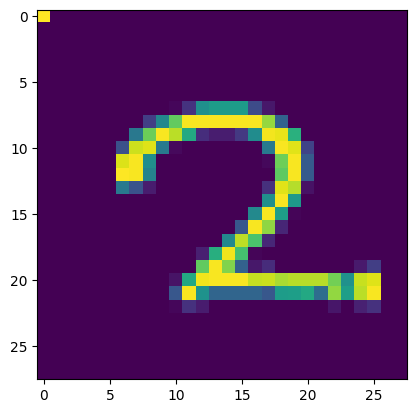

Real: 2
Predicted: 7
Rank of the correct answer: 2
Probabilities: [-0.0166231   0.09584678  0.39196455 -0.23724626  0.12517182  0.11163619
  0.07069253  0.41286161 -0.11696029  0.07467405] 

Image no. 80


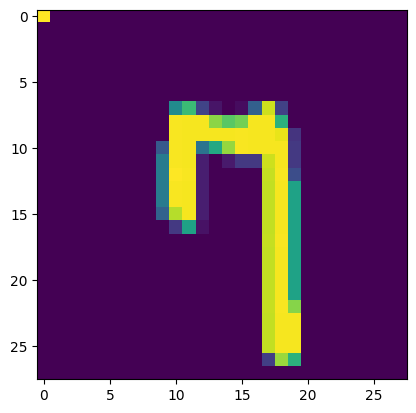

Real: 7
Predicted: 9
Rank of the correct answer: 2
Probabilities: [ 0.10781509 -0.13303982 -0.01190414  0.06044388  0.10069472  0.10019941
  0.00430467  0.44161806 -0.19434251  0.50942149] 

Image no. 92


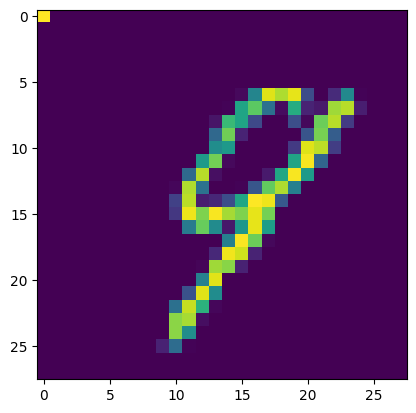

Real: 9
Predicted: 4
Rank of the correct answer: 2
Probabilities: [ 0.01491333  0.09968299  0.07817748 -0.02782986  0.25570433  0.05877023
  0.04344258  0.105886    0.085185    0.18575543] 

Image no. 97


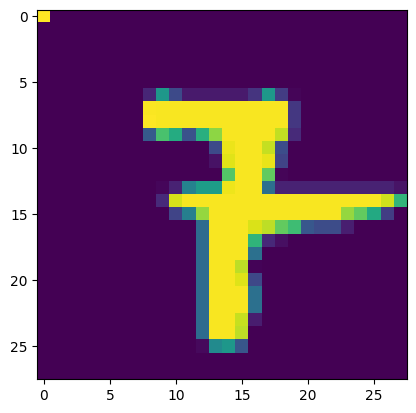

Real: 7
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.10859556  0.42963549 -0.15049236  0.20338289  0.14273784  0.00367364
  0.22254243  0.36102859 -0.01711557 -0.00275989] 

Image no. 111


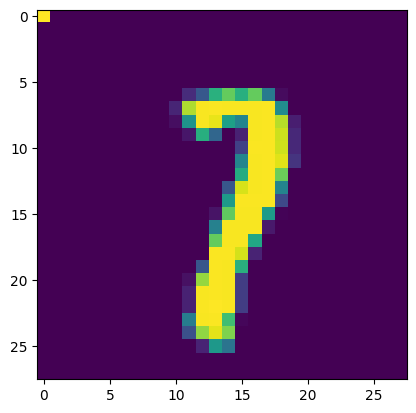

Real: 7
Predicted: 1
Rank of the correct answer: 2
Probabilities: [-0.05950157  0.51291562  0.08376928  0.15744238 -0.0903743  -0.01337797
 -0.03162151  0.22523586  0.02893545  0.18489858] 

Image no. 124


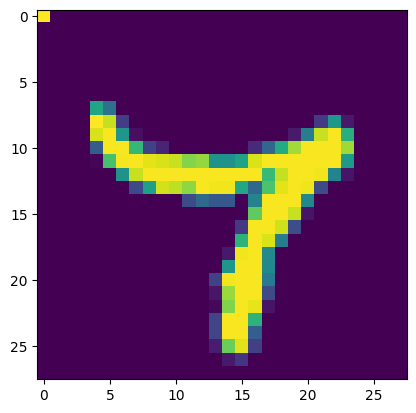

Real: 7
Predicted: 4
Rank of the correct answer: 2
Probabilities: [-0.2234444   0.00794311 -0.24002489  0.16710828  0.38147653 -0.06748357
  0.0715589   0.3427552   0.27493831  0.27106622] 

Image no. 149


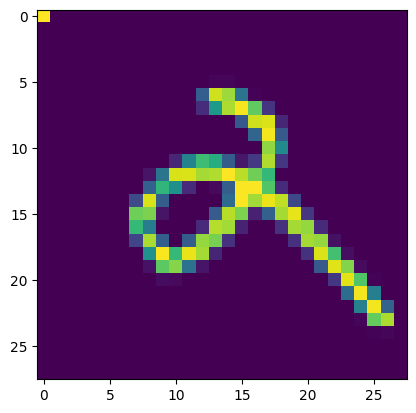

Real: 2
Predicted: 1
Rank of the correct answer: 4
Probabilities: [-0.01405083  0.26406973  0.09704728  0.04699957  0.20472764  0.05430158
  0.03932891 -0.14749582  0.09218502  0.26240422] 

Image no. 167


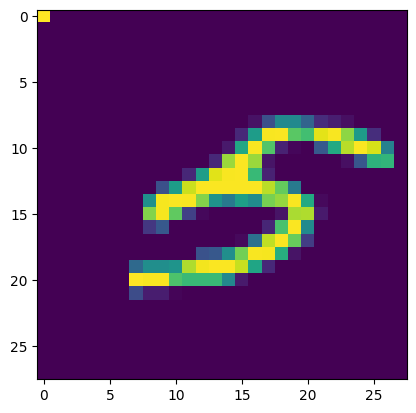

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.03666892  0.21142097  0.02565187  0.2875813   0.21562212  0.24789407
  0.00541988 -0.01713232 -0.02738404 -0.05335162] 

Image no. 187


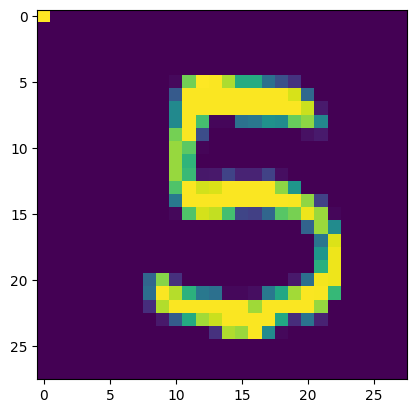

Real: 5
Predicted: 3
Rank of the correct answer: 2
Probabilities: [ 0.11333781 -0.04591545  0.11541755  0.38171485 -0.02827081  0.36768551
 -0.0959494  -0.20967416  0.17029475  0.19306254] 

Image no. 195


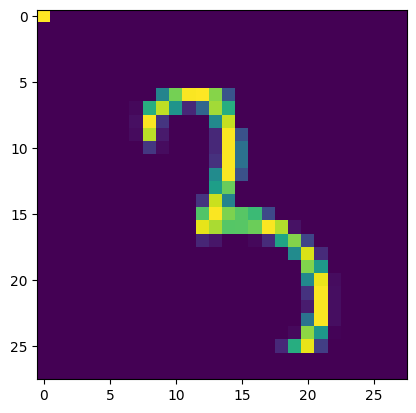

Real: 3
Predicted: 5
Rank of the correct answer: 3
Probabilities: [-0.12085922  0.00443375  0.07694146  0.13435959  0.08028235  0.21386106
  0.07809296  0.06363015  0.12357257  0.18208439] 



In [21]:
def find_pos(item, lst): 
    pos = [i for (z, i) in zip(lst, range(len(lst))) if item == z] 
    return pos

def display_sample(sample: np.ndarray):

    sample = np.array(sample, dtype='float')
    pixels = np.zeros((28,28))

    for i in range(28):
        for j in range(28):
            pixels[i,j] = sample[i * 28 + j]

    pixels = pixels.reshape((28, 28))
    plt.imshow(pixels, cmap='viridis')
    plt.show()

yt_estimate = np.matmul(Xt,W)
for i in range(200):
    if yyt[i][np.argmax(yt_estimate[i,:])] != 1:
      print(f"Image no. {i}")
      display_sample(Xt[i])
      print(f"Real: {np.argmax(yyt[i,:])}")
      print(f"Predicted: {np.argmax(yt_estimate[i,:])}")
      value = yt_estimate[i,np.argmax(yyt[i,:])]
      v_sorted = np.sort(yt_estimate[i,:])
      value_index = find_pos(value,v_sorted)
      print(f"Rank of the correct answer: {10 - value_index[0]}")
      print(f"Probabilities: {yt_estimate[i,:]} \n")

a) Sim, após diversas execuções o código retorna, na maior parte dos casos (em 60 dos 100 casos testados), o limite 2^10 na busca grossa

b) Classes 6 e 9, respectivamente. Foram as classes que apresentaram a maior quantidade de classificações erradas (acima de 20% em diversas execuções)
Teoricamente faz sentido, por serem justamente classes que apresentam poucos traços exclusivos

c) Determinar os elementos mais distintos de cada classe afim de distingui-las, seja por meio dos traços exclusivos ou pelos espaços em branco, a presença ou ausência de determinado traço influencia a determinação da classe

d) Por motivos de não generalizar bem, a ideia de expor a rede a uma quantidade grande de dados é justamente para fazer com que ela aprenda sobre a variabilidade dos dados, para que assim ela possa ser capaz de identificar diversos representações da mesma informação

e) Verifica os casos de erro nos primeiros 200 amostras do conjunto de teste.
Caso a classificação não corresponda à classe real, o código então exibe a imagem, a classe real, a classe atribuída e a posição da classe real no vetor de probabilidades do classificador, ilustrando o quão bem, ou quão mal, foi a atuação do classificador.
Os resultados demonstram uma boa atuação do classificador de um modo geral, alguns manuscritos foram confusos até para o aluno.